In [120]:
import pandas as pd
import numpy as np
import html

In [121]:
# clean users_df
users_df = pd.read_csv("data/Users.csv")
users_df.drop(["DisplayName", "CreationDate", "LastAccessDate", "Location", "Views", "WebsiteUrl", "EmailHash", "AboutMe", "ProfileImageUrl"], inplace=True, axis=1)

users_df.head(2)

,Id,Reputation,UpVotes,DownVotes,AccountId
0,522347,36,0,0,676260
1,521796,131,0,0,247214


In [122]:
postHistory_df = pd.read_csv("data/PostHistory.csv")
postHistory_df.drop(["ContentLicense", "AcceptedAnswerId", "OwnerDisplayName", "CommunityOwnedDate", "ParentId", "ClosedDate", "LastActivityDate", "LastEditDate", "LastEditorDisplayName", "LastEditorUserId", "CreationDate", "DeletionDate", "FavoriteCount"], inplace=True, axis=1)

# drop random line with str
postHistory_df.drop(postHistory_df[postHistory_df["OwnerUserId"] == "OwnerUserId"].index, inplace=True)

# limitaiton: ViewCount NaN's converted to 0
postHistory_df["ViewCount"].fillna(0, inplace=True)
postHistory_df["Title"].fillna("", inplace=True)
postHistory_df["Tags"].fillna("", inplace=True)
postHistory_df["AnswerCount"].fillna(0, inplace=True)
postHistory_df["Body"].fillna('', inplace=True)

# get rid of escape characters and html tags
postHistory_df["Title"] = postHistory_df["Title"].apply(html.unescape)
postHistory_df["Body"] = postHistory_df["Body"].apply(html.unescape)
postHistory_df["Body"] = postHistory_df["Body"].replace(r"<[^>]+>", ' ', regex=True)

# make tags an array
def extract_tags(tags_string): return tags_string.strip().strip("<>").split("><")
postHistory_df["Tags"] = postHistory_df["Tags"].apply(extract_tags)

postHistory_df.head(4)

,Id,PostTypeId,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
0,15176,1,10,1480.0,"I have a product, X, which we deliver to a cl...",1836,How to gauge the quality of a software product,[testing],7.0,0
1,15193,2,13,0.0,Advantages for Stored procedures : \n\n More...,1836,,[],0.0,1
2,27694,2,3,0.0,I highly recommend Stylus Studio if you hav...,2978,,[],0.0,0
3,27706,2,1,0.0,The only time I've done something like this i...,2978,,[],0.0,0


In [123]:
# joining user post activity with users_df
# num posts
num_posts_df = postHistory_df.groupby("OwnerUserId").size()


post_enums = {
    "Question": 1,
    "Answer": 2
}

# add in numPosts to each user
for user_id, num_posts in num_posts_df.items():

    # add in total posts for user
    users_df.loc[users_df["Id"] == user_id, "NumPosts"] = num_posts

    # grouping to find more information about a user's activity
    user_posts = postHistory_df[postHistory_df["OwnerUserId"] == user_id]
    type_of_posts = user_posts.groupby("PostTypeId")
    num_posts = type_of_posts["Id"].count()
    avg_posts = type_of_posts["Score"].mean()


    for post_type, enum_val in post_enums.items():
        # checks if user has made a post of the current type (Question or Answer)
        num_type_posts = num_posts.loc[enum_val] if enum_val in num_posts.index else 0
        avg_score = avg_posts.loc[enum_val] if enum_val in num_posts.index else 0

        users_df.loc[users_df["Id"] == user_id, f"Num{post_type}s"] = num_type_posts
        users_df.loc[users_df["Id"] == user_id, f"Avg{post_type}Score"] = avg_score

users_df.head(4)



,Id,Reputation,UpVotes,DownVotes,AccountId,NumPosts,NumQuestions,AvgQuestionScore,NumAnswers,AvgAnswerScore
0,522347,36,0,0,676260,1.0,0.0,0.00,1.0,2.0
1,521796,131,0,0,247214,5.0,4.0,1.75,1.0,5.0
2,520897,41,4,0,246644,5.0,4.0,0.75,1.0,-2.0
3,519890,73,0,0,246019,2.0,1.0,2.00,1.0,5.0


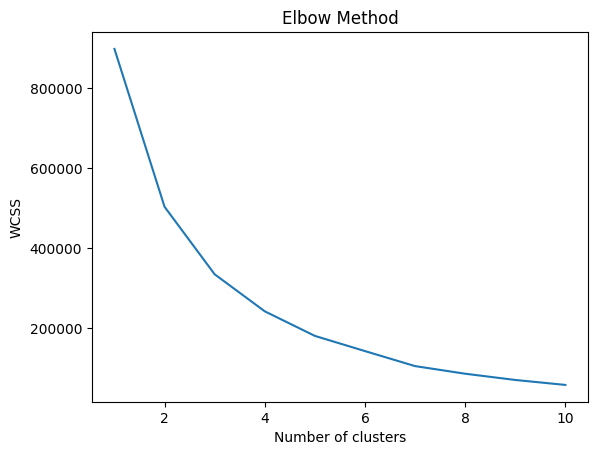

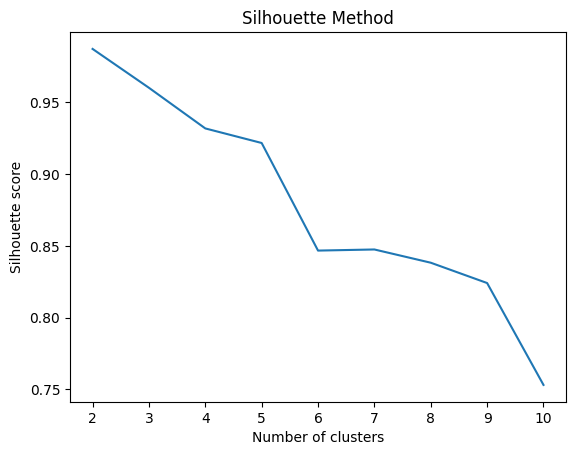

In [124]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

data = users_df[["AvgQuestionScore", "AvgAnswerScore"]].values # "AvgQuestionScore", "AvgAnswerScore"

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Use the silhouette method to validate the elbow method
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_, metric='euclidean')
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


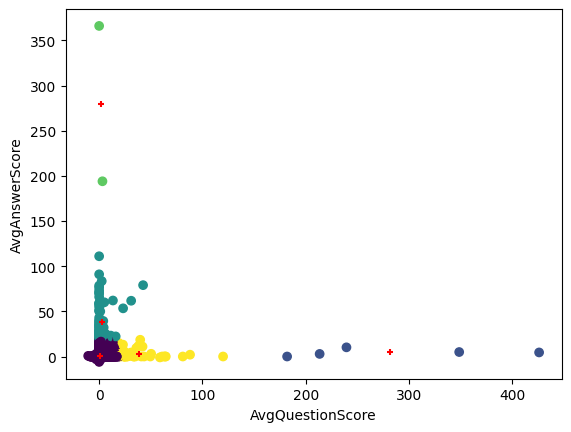

,Reputation,NumPosts,NumQuestions,NumAnswers,AvgQuestionScore,AvgAnswerScore
0,239.986707,8.935001,4.050468,4.872141,6.978729,7.218526
2,2846.986486,11.716216,3.202703,8.500000,28.712896,387.207786
3,2948.500000,3.500000,2.500000,1.000000,16.000000,2800.000000
4,3846.441860,29.116279,9.697674,19.372093,384.148397,26.708889
1,17204.600000,17.800000,5.600000,11.800000,2819.173077,44.917749


In [133]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# k-means with reputation and numposts
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)

labels = kmeans.labels_
users_df['Cluster'] = labels

labels = kmeans.labels_
centers = kmeans.cluster_centers_

# scatter plot dis bih
plt.scatter(data[:, 0], data[:, 1], c=labels)

# plot center of each group
plt.scatter(centers[:, 0], centers[:, 1], marker='+', s=25, color='red')

plt.xlabel("AvgQuestionScore")
plt.ylabel("AvgAnswerScore")
plt.show()


users_df.head(10)

analysis_df = pd.DataFrame(columns=["Reputation", "NumPosts"])

for label in set(labels):
    cluster = users_df[users_df['Cluster'] == label]
    new_row = pd.DataFrame([
        {
            'Reputation': cluster["Reputation"].mean(),
            'NumPosts': cluster["NumPosts"].mean(),
            'NumQuestions': cluster["NumQuestions"].mean(),
            'NumAnswers': cluster["NumAnswers"].mean(),
            'AvgQuestionScore': cluster["AvgQuestionScore"].mean() * 10, # multiply by 10 because that's how much rep 1 score point is worth (https://stackoverflow.help/en/articles/4396982-reputation)
            'AvgAnswerScore': cluster["AvgAnswerScore"].mean() * 10,
        }
    ])

    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

analysis_df.sort_values("Reputation", ascending=True).head(20)


In [157]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words="english", max_features=50, token_pattern=r"(?u)\b\w[\w']+\b")

for post_type in post_enums:
    analysis_df[f"Avg{post_type}Length"] = 0

for i, content in analysis_df.iterrows():
    print("??")
    users_in_cluster = users_df[users_df["Cluster"] == i]

    # posts from cluster
    posts = postHistory_df[postHistory_df['OwnerUserId'].isin(list(users_in_cluster["Id"]))]

    for post_type, enum_val in post_enums.items():
        posts_of_type = posts[posts["PostTypeId"] == enum_val]
        analysis_df.loc[i, f"Avg{post_type}Length"] = posts_of_type["Body"].apply(lambda x: len(x)).mean()
        
analysis_df = analysis_df.sort_values("Reputation")
        
analysis_df.head(10)


??
??
??
??
??


,Reputation,NumPosts,NumQuestions,NumAnswers,AvgQuestionScore,AvgAnswerScore,AvgQuestionLength,AvgAnswerLength
0,239.986707,8.935001,4.050468,4.872141,6.978729,7.218526,1256.393703,586.178705
2,2846.986486,11.716216,3.202703,8.500000,28.712896,387.207786,1194.915612,611.343402
3,2948.500000,3.500000,2.500000,1.000000,16.000000,2800.000000,1116.200000,566.500000
4,3846.441860,29.116279,9.697674,19.372093,384.148397,26.708889,847.736211,464.015606
1,17204.600000,17.800000,5.600000,11.800000,2819.173077,44.917749,639.071429,393.084746


In [127]:
# What are some of the best questions-- questions that have generated high scores
# for our analysis, we are uing the top 100
questions_df = postHistory_df[postHistory_df["PostTypeId"] == post_enums["Question"]]
questions_df = questions_df.sort_values("Score", ascending=False).iloc[:100]


In [128]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# What makes the question 'good'-- look for keywords, so on
# regex in token ensures grabbing words-- by default, will ignore apostrophes
count_vectorizer = CountVectorizer(stop_words="english", max_features=50, token_pattern=r"(?u)\b\w[\w']+\b")

# keywords in title
title_word_counts = count_vectorizer.fit_transform(questions_df["Title"])
title_keywords = count_vectorizer.get_feature_names_out()

# keywords in body
count_vectorizer.max_features = 100
body_word_counts = count_vectorizer.fit_transform(questions_df["Body"])
body_keywords = count_vectorizer.get_feature_names_out()

tag_counter = Counter()
for tags in questions_df["Tags"]:
    tag_counter.update(tags)

common_tags = tag_counter.most_common(20)

# 5. Investigate engagement metrics
average_viewcount = np.mean(questions_df["ViewCount"])
average_answercount = np.mean(questions_df["AnswerCount"])
average_commentcount = np.mean(questions_df["CommentCount"])

print("Title keywords:", title_keywords)
print("Body keywords:", body_keywords)
print("Common tags:", common_tags)
print("Average view count:", average_viewcount)
print("Average answer count:", average_answercount)
print("Average comment count:", average_commentcount)

Title keywords: ['add' 'android' 'command' 'connection' 'convert' 'converting' 'create'
 'debug' 'defined' 'dialog' 'difference' 'does' 'eclipse' 'error' 'file'
 'images' 'import' 'index' 'initial' 'java' 'jquery' 'js' 'list' 'make'
 'mean' 'method' 'module' 'multiple' 'mysql' 'new' 'node' 'non' 'package'
 'pip' 'private' 'project' 'python' 'rest' 'server' 'source' 'sql'
 'static' 'stored' 'string' 'test' 'text' 'use' 'using' 'value' 'values']
Body keywords: ['10' '18' 'add' 'android' 'app' 'application' 'build' 'button' 'class'
 'code' 'com' 'command' 'console' 'const' 'data' 'dev' 'dialog'
 'different' 'does' "don't" 'echweb' 'error' 'event' 'example' 'file'
 'files' 'following' 'function' 'git' 'github' "i'd" "i'm" "i've"
 'implementation' 'import' 'include' 'install' 'internal' "it's" 'java'
 'javax' 'js' 'json' 'just' 'know' 'lib' 'like' 'list' 'main' 'make'
 'method' 'module' 'modules' 'need' 'new' 'node' 'node_modules' 'null'
 'object' 'output' 'package' 'page' 'path' 'pip' 'pos